In [165]:
import pandas as pd
import numpy as np
import time
import datetime
import requests
import json
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from random import randint
from bs4 import BeautifulSoup
from selenium import webdriver
from tqdm import tqdm
from glob import glob
from datetime import timedelta

In [166]:
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'JejuGothic'

### Basic Data

In [2]:
my_api_key = ''

In [3]:
df = pd.read_csv('C:/Users/rsh15/Desktop/seunghuni/lol_analysis/data/lol_api/high_tier_user_1009.csv')

In [6]:
df[df['summonerName']=='Hide on bush'][['summonerName','puuid']]

,summonerName,puuid
4160,Hide on bush,WtTsQKePbPTEtwvNVXSm97PwF5rmYj5T2qsHXRm8vlmR8h...


### Get match_id

In [8]:
dates_range = pd.date_range(start='2021/06/16', end='2021/10/30',freq='1D')
print(len(dates_range),'days')

137 days


In [9]:
date_start_list = []
date_end_list = []
for dd in dates_range:
    date_start_list.append(int(time.mktime(datetime.datetime(
        dd.year, dd.month, dd.day, 0, 0, 0).timetuple()
    )))
    
    date_end_list.append(int(time.mktime(datetime.datetime(
        dd.year, dd.month, dd.day, 23, 59, 59).timetuple()
    )))

In [10]:
match_id_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?startTime={}&endTime={}&type=ranked&start=0&count=100&api_key={}'

In [11]:
urls_list = []
for start_d, end_d in zip(date_start_list,date_end_list):
    urls_list.append(
        match_id_url.format(df['puuid'][4160],start_d,end_d,my_api_key))

In [12]:
i = 0
match_ids = []
for urll in tqdm(urls_list):
    if i == 99:
        time.sleep(120)        
        i = 0
    else:
        i += 1
        
    reqq = eval(requests.get(urll).text)
    match_ids += reqq

100%|██████████| 137/137 [02:39<00:00,  1.17s/it]


In [13]:
print(len(match_ids),'game')

527 game


In [22]:
print(len(np.unique(match_ids)),'unique games')

527 unique games


### Get match data

In [23]:
match_hist_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'

In [24]:
match_hist_header = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.71 Safari/537.36",
    "Accept-Language": "ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com"
}

In [92]:
def write_json_file(request_text,match_id):
    with open('C:/Users/rsh15/Desktop/seunghuni/lol_analysis/data/hide on bush/data_{}.json'.format(match_id),'w') as f:
        json.dump(request_text, f)

In [93]:
match_hist = []
i = 0
for match_id in tqdm(match_ids):

    try:
        reqq = requests.get(match_hist_url.format(match_id,my_api_key),headers=match_hist_header).text

        if reqq == '{"status":{"message":"Rate limit exceeded","status_code":429}}':
            time.sleep(120)

            reqq = requests.get(match_hist_url.format(match_id,my_api_key),headers=match_hist_header).text
            write_json_file(reqq,match_id)

        else:
            write_json_file(reqq,match_id)

    except:
        time.sleep(30)
        reqq = requests.get(match_hist_url.format(match_id,my_api_key),headers=match_hist_header).text

        if reqq == '{"status":{"message":"Rate limit exceeded","status_code":429}}':
            time.sleep(120)

            reqq = requests.get(match_hist_url.format(match_id,my_api_key),headers=match_hist_header).text
            write_json_file(reqq,match_id)

        else:
            write_json_file(reqq,match_id)

100%|██████████| 527/527 [12:58<00:00,  1.48s/it]  


### Preprocessing 

#### Sample Preprocessing

In [93]:
sample_json = json.loads(reqq)

In [99]:
[x for x in sample_json.keys()]

['metadata', 'info']

In [100]:
sample_json['metadata']

{'dataVersion': '2',
 'matchId': 'KR_5476190678',
 'participants': ['miX-Ec18NSvbEfg7ZVC5U2gMGUnWrFWNtPF1rrVShw8sUBjphcQ95z16kSySlYl3Z-UX4uBQt9whmw',
  'wurdMhgmPY4h0njsbBrtpona7Ev9ZwA7Mq16OHijwCAyFYC64n2XJATTVXCCvtifObhFvlAOZyIqtw',
  'yJCHxAO50M_nKpX6REdXf037ETg4slC6G_Ln2XcmQzZvbPVRjuVZQthUvjUyUqQVbDFBn_Yh41aF6A',
  'MxfGQjIMNAhKFebnMwvz0-9KkTSpotOhSY81JquAfq_qEL13WgRZnA2LouWYTCTWEo7_MUjnbC86Rw',
  'ZPevuzNMbmrNuCgok1NWgIAdiy0LUy8DzvNw4dPZJtqHsRQP8ztY06B-r74ewrRoXZx-JdMCl4Ur0w',
  'Q0ucTiDnPFhILDTOjUttDj7Mr6EfCoGOEOUPQY8X-TsVNKYqZide__fLb1c3uQ2KMsKqK-OHB7W2Lw',
  'WtTsQKePbPTEtwvNVXSm97PwF5rmYj5T2qsHXRm8vlmR8hPBA5E3hf4hDC8S_5UHEMZkZOS9CfWEKQ',
  '6KNPMsWYUl43fbMegw4stpZwuqrWUUoQIRX1-1f9XVbIcDdQ_znlBPxf1PkSmT1wKaLwBc54ygUrCw',
  'X1oqF2m_5yBhA885PxuwIjX5b2-O60TZOTJvjPH0Hga6vxH_NkSrr1MnCugwHpWTFpUpsSoi0ajsfg',
  '2nOdCLN3-YEfC12GuVKIPBeDKtQuownkfCSDcx5HpH9283WE8Yj5W-qbte7oFuYyNjhgmCxR26WQzA']}

In [105]:
[x for x in sample_json['info'].keys()]

['gameCreation',
 'gameDuration',
 'gameId',
 'gameMode',
 'gameName',
 'gameStartTimestamp',
 'gameType',
 'gameVersion',
 'mapId',
 'participants',
 'platformId',
 'queueId',
 'teams',
 'tournamentCode']

In [110]:
for info_col in ['gameCreation','gameDuration','gameId','gameMode','gameName','gameStartTimestamp',
                 'gameType','gameVersion','mapId','platformId','queueId','tournamentCode']:
    print(info_col,':',sample_json['info'][info_col])

gameCreation : 1632582258000
gameDuration : 1694571
gameId : 5476190678
gameMode : CLASSIC
gameName : teambuilder-match-5476190678
gameStartTimestamp : 1632582277499
gameType : MATCHED_GAME
gameVersion : 11.19.398.9466
mapId : 11
platformId : KR
queueId : 420
tournamentCode : 


In [118]:
part_user = sample_json['info']['participants'][0]
part_user['perks']

{'statPerks': {'defense': 5002, 'flex': 5008, 'offense': 5005},
 'styles': [{'description': 'primaryStyle',
   'selections': [{'perk': 8214, 'var1': 411, 'var2': 1085, 'var3': 0},
    {'perk': 8226, 'var1': 250, 'var2': 545, 'var3': 0},
    {'perk': 8210, 'var1': 1, 'var2': 0, 'var3': 0},
    {'perk': 8237, 'var1': 257, 'var2': 0, 'var3': 0}],
   'style': 8200},
  {'description': 'subStyle',
   'selections': [{'perk': 8345, 'var1': 3, 'var2': 0, 'var3': 0},
    {'perk': 8352, 'var1': 143, 'var2': 1003, 'var3': 637}],
   'style': 8300}]}

In [143]:
sample_json['info']['participants']

[{'assists': 6,
  'baronKills': 0,
  'bountyLevel': 0,
  'champExperience': 10207,
  'champLevel': 13,
  'championId': 26,
  'championName': 'Zilean',
  'championTransform': 0,
  'consumablesPurchased': 3,
  'damageDealtToBuildings': 2768,
  'damageDealtToObjectives': 3039,
  'damageDealtToTurrets': 2768,
  'damageSelfMitigated': 3792,
  'deaths': 3,
  'detectorWardsPlaced': 3,
  'doubleKills': 0,
  'dragonKills': 0,
  'firstBloodAssist': False,
  'firstBloodKill': False,
  'firstTowerAssist': False,
  'firstTowerKill': False,
  'gameEndedInEarlySurrender': False,
  'gameEndedInSurrender': False,
  'goldEarned': 8045,
  'goldSpent': 7775,
  'individualPosition': 'TOP',
  'inhibitorKills': 0,
  'inhibitorTakedowns': 0,
  'inhibitorsLost': 1,
  'item0': 2033,
  'item1': 3158,
  'item2': 3165,
  'item3': 1028,
  'item4': 6656,
  'item5': 0,
  'item6': 3340,
  'itemsPurchased': 17,
  'killingSprees': 0,
  'kills': 0,
  'lane': 'TOP',
  'largestCriticalStrike': 0,
  'largestKillingSpree': 0

In [119]:
part_user['perks'].keys()

dict_keys(['statPerks', 'styles'])

In [132]:
del part_user['perks']

In [146]:
part_user

{'assists': 6,
 'baronKills': 0,
 'bountyLevel': 0,
 'champExperience': 10207,
 'champLevel': 13,
 'championId': 26,
 'championName': 'Zilean',
 'championTransform': 0,
 'consumablesPurchased': 3,
 'damageDealtToBuildings': 2768,
 'damageDealtToObjectives': 3039,
 'damageDealtToTurrets': 2768,
 'damageSelfMitigated': 3792,
 'deaths': 3,
 'detectorWardsPlaced': 3,
 'doubleKills': 0,
 'dragonKills': 0,
 'firstBloodAssist': False,
 'firstBloodKill': False,
 'firstTowerAssist': False,
 'firstTowerKill': False,
 'gameEndedInEarlySurrender': False,
 'gameEndedInSurrender': False,
 'goldEarned': 8045,
 'goldSpent': 7775,
 'individualPosition': 'TOP',
 'inhibitorKills': 0,
 'inhibitorTakedowns': 0,
 'inhibitorsLost': 1,
 'item0': 2033,
 'item1': 3158,
 'item2': 3165,
 'item3': 1028,
 'item4': 6656,
 'item5': 0,
 'item6': 3340,
 'itemsPurchased': 17,
 'killingSprees': 0,
 'kills': 0,
 'lane': 'TOP',
 'largestCriticalStrike': 0,
 'largestKillingSpree': 0,
 'largestMultiKill': 0,
 'longestTimeSpe

#### Preprocessing function

In [97]:
def riot_json_preprocessing(json_data):
    json_data = json.loads(json_data)
    matchid = json_data['metadata']['matchId']
    
    return_dfs = []
    for json_user in json_data['info']['participants']:
        return_dict = {}
        perks = str(json_user['perks'])
        del json_user['perks']
    
        json_user['matchId'] = matchid
        json_user['perks'] = perks
        return_dfs.append(pd.DataFrame(json_user,index=[0]))
    
    return pd.concat(return_dfs).reset_index(drop=True)

#### Make bind data

In [95]:
data_path = glob('C:/Users/rsh15/Desktop/seunghuni/lol_analysis/data/hide on bush/*.json')
raw_json = []
for path in data_path:
    with open(path,'r') as f:
        raw_json.append(json.load(f))

In [98]:
faker_df = list(map(riot_json_preprocessing,raw_json))
faker_df = pd.concat(faker_df)
faker_df = faker_df.reset_index(drop=True)
faker_df.head(5)

,assists,baronKills,bountyLevel,champExperience,champLevel,championId,championName,championTransform,consumablesPurchased,damageDealtToBuildings,...,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,matchId,perks,inhibitorTakedowns,nexusTakedowns,turretTakedowns
0,6,0,0,14987,16,887,Gwen,0,3,5715,...,15,2,1,6,True,KR_5265344658,"{'statPerks': {'defense': 5002, 'flex': 5008, ...",NaN,NaN,NaN
1,10,1,0,12992,14,78,Poppy,0,6,2646,...,32,6,5,6,True,KR_5265344658,"{'statPerks': {'defense': 5002, 'flex': 5008, ...",NaN,NaN,NaN
2,7,0,2,16214,16,236,Lucian,0,8,9738,...,49,7,13,16,True,KR_5265344658,"{'statPerks': {'defense': 5003, 'flex': 5008, ...",NaN,NaN,NaN
3,9,0,7,14664,15,110,Varus,0,4,5347,...,23,1,6,6,True,KR_5265344658,"{'statPerks': {'defense': 5002, 'flex': 5008, ...",NaN,NaN,NaN
4,19,0,0,9690,12,412,Thresh,0,12,587,...,61,10,7,34,True,KR_5265344658,"{'statPerks': {'defense': 5002, 'flex': 5003, ...",NaN,NaN,NaN


In [99]:
#faker_df.to_csv('C:/Users/rsh15/Desktop/seunghuni/lol_analysis/data/hide on bush/faker_df.csv',index=False,encoding='utf-8-sig')

### eda

#### 가장 많이 만난 유저?

In [100]:
faker_df.groupby('summonerName',as_index=False).size().sort_values('size',ascending=False)[0:20]

,summonerName,size
302,Hide on bush,527
527,T1 Canna,21
1144,고등학생,21
114,BJ갈배,21
414,Mocha,16
366,La Casa de PapeI,15
165,Cuzzzzzzz,14
1789,현주입니다,14
1325,무인데용,13
1669,짜요짜요먹고싶어,12


#### 어떤 챔피언을 많이 썼을까?

In [237]:
champions_count = faker_df[faker_df['summonerName']=='Hide on bush'].groupby(
    'championName',as_index=True)['win'].agg(['mean','count']).sort_values('count',ascending=False)
total_champ = len(champions_count)
champions_count = champions_count[champions_count['count']>5]
win_df = champions_count['count'] * champions_count['mean']
win_rt = [str(round(x * 100,1)) + '%' for x in champions_count['mean']]

총 사용된 챔피언 76개, 그 중 5게임 이상 사용된 챔피언 24개


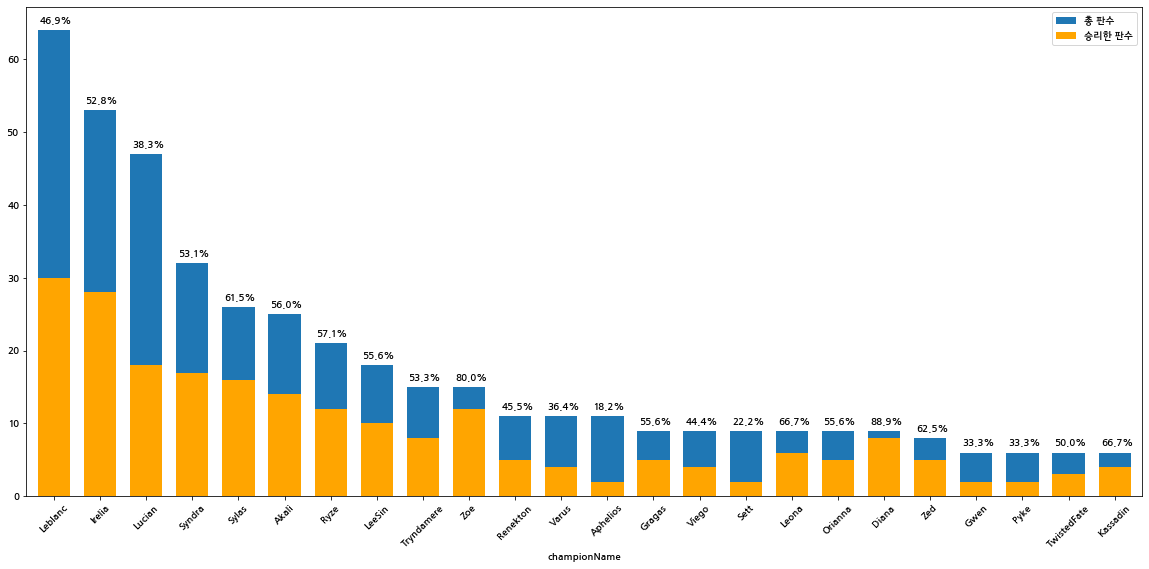

In [238]:
print('총 사용된 챔피언 {}개, 그 중 5게임 이상 사용된 챔피언 {}개'.format(total_champ,len(champions_count)))
champions_count.plot.bar(y='count',figsize=(20,9),width=0.7,legend=None);
win_df.plot.bar(color='orange',width=0.7)
plt.legend(['총 판수','승리한 판수'])
for a in range(len(champions_count)):
    plt.text(a-0.3,champions_count['count'][a]+1,win_rt[a]);
plt.xticks(rotation=45);

#### 퍼블 & 어시스트?

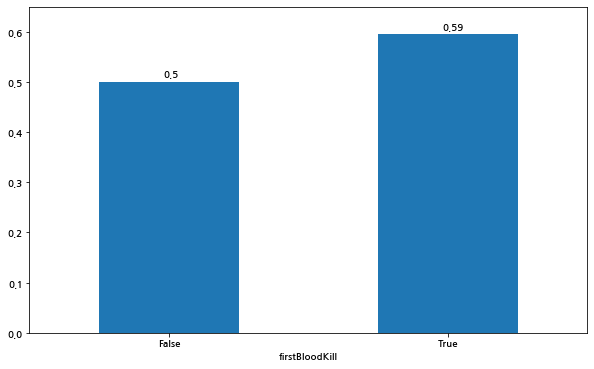

In [269]:
first_blood_win = faker_df[['matchId','teamId','firstBloodKill','win']].drop_duplicates().groupby('firstBloodKill')['win'].mean()

plt.figure(figsize=(10,6))
first_blood_win.plot.bar()
plt.text(0-0.02,first_blood_win[0]+0.01,first_blood_win[0])
plt.text(1-0.02,first_blood_win[1]+0.01,round(first_blood_win[1],2))
plt.xticks(rotation=0);
plt.ylim(0,0.65);

#### 여기다?

In [270]:
faker_df.columns

Index(['assists', 'baronKills', 'bountyLevel', 'champExperience', 'champLevel',
       'championId', 'championName', 'championTransform',
       'consumablesPurchased', 'damageDealtToBuildings',
       ...
       'visionScore', 'visionWardsBoughtInGame', 'wardsKilled', 'wardsPlaced',
       'win', 'matchId', 'perks', 'inhibitorTakedowns', 'nexusTakedowns',
       'turretTakedowns'],
      dtype='object', length=106)

In [275]:
faker_df[faker_df['summonerName']=='Hide on bush']['lane'].unique()

array(['MIDDLE', 'NONE', 'TOP', 'JUNGLE', 'BOTTOM'], dtype=object)

In [278]:
pd.DataFrame(np.unique(faker_df[faker_df['summonerName']=='Hide on bush']['lane'],return_counts=True)).T

,0,1
0,BOTTOM,67
1,JUNGLE,33
2,MIDDLE,268
3,NONE,117
4,TOP,42
